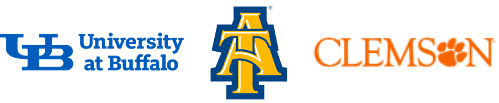

# Lab 3: Cyberbullying Detection Using BERT

In this lab, we will learn how AI can be developed to detect cyberbullying. We will use a publicly available dataset of cyberbullying texts, and train an AI model on this dataset to automatically detect cyberbullying text. You will learn:

1. AI development process
2. Train and test your own AI for cyberbullying detection
3. Run AI on your own samples
4. Hypterpaprameter tuning to improve model performance

First, we need to download softwares used in the lab. Just hit the 'play' button run the code below.

### Preliminaries

In [4]:
# change the output font size
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 20px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [5]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# !git clone https://github.com/nishantvishwamitra/CyberbullyingLab1.git

Next, we install transformers which offer us some tools we can use

In [7]:
# !pip install transformers

Let's import all our softwares dependencies in our iPython notebook

In [8]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from transformers import AdamW

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [11]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Preprocessing

While training AI, datasets are divided into three parts: training dataset, validation dataset and test dataset.
- Training set: feed the AI, so the AI can keep learning cyberbullying and non-cyberbullying knowledge.
- Validation set:  can help us and the AI know whether its predictions are getting better or worse.
- Test set: is to evaluate the AI’s performance.

They are different datasets, should have no overlap among them.
Let's create these three parts for our dataset.

In [12]:
# Dowload cyberbullying speech dataset
main_df = pd.read_csv('CyberbullyingLab1/formspring_dataset.csv', sep = '\t')

#  how many samples?
print('Total number of samples:', main_df.shape)
main_df = main_df.sample(n = main_df.shape[0])
main_df = main_df[['text', 'label']]

# peek at them
main_df.head()

Total number of samples: (13159, 2)


,text,label
12103,Q: how many babies have you ate?<br>A: I'm wor...,0
6522,Q: IDGAF LAME BITCH<br>A: Lol whyy are you sti...,1
9325,Q: haha thanks and i LOVEDDDDDDDDDD reading yo...,0
10009,Q: ask me a question? (:(:(:<br>A: okay you r...,1
9037,Q: What is your opinion on &quot;open&quot; re...,0


Note:
* 0 indicates non-cyberbullying
* 1 indicates cyberbullying

In [13]:
# divide the dataset by non-cyberbullying and cyberbullying samples
o_class = main_df.loc[main_df.label == 0, :]
l_class = main_df.loc[main_df.label == 1, :]

# create train, val and test splits
train_val = main_df.iloc[:int(main_df.shape[0] * .80)]
test_df = main_df.iloc[int(main_df.shape[0] * .80):]
train_df = train_val.iloc[:int(train_val.shape[0] * .80)]
val_df = train_val.iloc[int(train_val.shape[0] * .80):]

#print(train.shape, val.shape, test.shape)
print('\nTraining set:\n', train_df.label.value_counts())
print('\nValidation set:\n', val_df.label.value_counts())
print('\nTest set:\n', test_df.label.value_counts())


Training set:
 label
0    7869
1     552
Name: count, dtype: int64

Validation set:
 label
0    1943
1     163
Name: count, dtype: int64

Test set:
 label
0    2479
1     153
Name: count, dtype: int64


The first step in natural language processing for AI is tokenization. In this process, we split the text into 'tokens', that are then given unique numbers that are understood by a machine. Take a look at the example below.

In [14]:
# Let's use a tokenizer. This is the first step in NLP
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
#  Let's see how the tokenizer works
sentences = "the cat sat on the mat"

tokens = tokenizer.tokenize(sentences)
for token in tokens:
    print(token)

the
cat
sat
on
the
mat


- - - -
**<font color='red'>Task 1:</font>
Add code below to preprocess the following cyberbullying text, and include the generated tokens in your report.**<br>
“Harlem shake is just an excuse to go full retard for 30 seconds”.
- - - -

In [16]:
# TODO: Enter your code here
#  Let's see how the tokenizer works
sentences = "Harlem shake is just an excuse to go full retard for 30 seconds"

tokens = tokenizer.tokenize(sentences)
for token in tokens:
    print(token)

harlem
shake
is
just
an
excuse
to
go
full
re
##tar
##d
for
30
seconds


With tokenizer, now we can prepare the input data that the AI model needs

In [17]:
# Prepare the dataset
class CyberbullyingDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text = df.text.to_list()
        self.label = df.label.to_list()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text, # Sentence to encode.
            None, # Add another sequence to the inputs. 'None' means no other sequence is added.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            max_length = self.max_len, # Pad & truncate all sentences.
            pad_to_max_length = True, # Pad all samples to the same length.
            truncation = True, # Truncate all samples to the same length.
            return_token_type_ids = False,
            return_tensors = 'pt' # Return pytorch tensors.
        )
        label = torch.tensor(self.label[index], dtype = torch.long)

        return {
            'text': text,
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': label
        }

# The number of unique words in the vocabulary and the number of labels
VOCAB_SIZE = tokenizer.vocab_size
NUM_LABELS = train_df.label.nunique()
print("The number of unique words in the vocabulary:", VOCAB_SIZE)
print("The number of labels:", NUM_LABELS)

The number of unique words in the vocabulary: 30522
The number of labels: 2


In order to make the model understand both cyberbullying and non-cyberbullying data, we typically balance the datasets.

In [18]:
# Build a balanced dataset
def balence_data(dataframe):
    o_class = dataframe.loc[dataframe.label == 0, :]
    l_class = dataframe.loc[dataframe.label == 1, :]
    o_class = o_class.sample(n = l_class.shape[0])
    dataframe = pd.concat([o_class, l_class], axis = 0)
    dataframe = dataframe.sample(n = dataframe.shape[0])
    return dataframe

train_df = balence_data(train_df)
val_df = balence_data(val_df)
test_df = balence_data(test_df)

print('\nTraining set:\n', train_df.label.value_counts())
print('\nValidation set:\n', val_df.label.value_counts())
print('\nTest set:\n', test_df.label.value_counts())


Training set:
 label
0    552
1    552
Name: count, dtype: int64

Validation set:
 label
0    163
1    163
Name: count, dtype: int64

Test set:
 label
1    153
0    153
Name: count, dtype: int64


We need iterators to step through our dataset.

In [19]:
# Normally, we prepare the dataset with batches, it can help us to train the model faster.
MAX_LEN = 120
BATCH_SIZE = 32

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CyberbullyingDataset(df, tokenizer, max_len)
    return DataLoader(ds, batch_size = batch_size)

# Create the dataloaders
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

print("After we build the dataloaders, we can see the number of batches in each dataloader. It means we can train the model with {} samples in each time.".format(BATCH_SIZE))
print("The number of batches in the training dataloader:", len(train_data_loader))
print("The number of batches in the validation dataloader:", len(val_data_loader))
print("The number of batches in the test dataloader:", len(test_data_loader))

After we build the dataloaders, we can see the number of batches in each dataloader. It means we can train the model with 32 samples in each time.
The number of batches in the training dataloader: 35
The number of batches in the validation dataloader: 11
The number of batches in the test dataloader: 10


We need iterators to step through our dataset.

Let's define some hyperparameters for our AI model, you can change them to adjust the performance of the model.

In [20]:
# Lets define some hyperparameters
N_EPOCHS = 5 # The number of epochs
LEARNING_RATE = 2e-5 # The learning rate
Num_classes = 2 # The number of classes

Let's instantiate our AI model.

In [21]:
# Download the tokenizer and model
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
bert_model = bert_model.to(device)

In [22]:
# Define the model
class CyberbullyingDetecter(nn.Module):
    def __init__(self, bert_model, Num_classes):
            super(CyberbullyingDetecter, self).__init__()
            self.bert = bert_model
            self.drop = nn.Dropout(p=0.3)
            self.out = nn.Linear(self.bert.config.hidden_size, Num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
        )['pooler_output']
        output = self.drop(pooled_output)
        return self.out(output)

# Create the model
model = CyberbullyingDetecter(bert_model, Num_classes)
model = model.to(device)

Now, let's define and the loss function.

In [23]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)

Define some functions for model training

In [24]:
# Let's define the training and testing procedures for our AI model
# Lets define our training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for d in tqdm(data_loader):
        inputs_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)
        # print(inputs_ids.shape, attention_mask.shape, label.shape)
        outputs = model(inputs_ids, attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define our testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for d in data_loader:
            inputs_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(inputs_ids, attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# define a function for evaluation
def predict_cb(sentence):
    sentence = str(sentence)
    sentence = ' '.join(sentence.split())
    inputs = tokenizer.encode_plus(
        sentence,  # Sentence to encode.
        None,  # Add another sequence to the inputs. 'None' means no other sequence is added.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=MAX_LEN,  # Pad & truncate all sentences.
        pad_to_max_length=True,  # Pad all samples to the same length.
        truncation=True,  # Truncate all samples to the same length.
        return_token_type_ids=True  # Return token_type_ids
    )
    output = model(torch.tensor(inputs['input_ids']).unsqueeze(0).to(device), torch.tensor(inputs['attention_mask']).unsqueeze(0).to(device))
    # print(output)
    preds, ind = torch.max(F.softmax(output, dim=-1), 1)
    if ind.item() == 1:
        return preds, ind, 'Cyberbullying detected.'
    else:
        return preds, ind, 'Cyberbullying not detected.'

In [25]:
def initialize_model():
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).to(device)
    return CyberbullyingDetecter(bert_model, Num_classes).to(device)


Next, Let's begin training our AI model

### Training Process

In [26]:
import os
import torch

model_path = './models/model_1.pth'

# Check if the model has already been saved
# if os.path.exists(model_path):
#     # Load the model state dictionary
#     model.load_state_dict(torch.load(model_path))
#     model.eval()  # Set the model to evaluation mode
#     print("Loaded saved model.")
# else:
# If the model hasn't been saved, train it
print("Training model...")
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_data_loader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

# Save the model's state dictionary
# torch.save(model.state_dict(), model_path)
print("Model trained and saved.")

Training model...


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.617 | Train Acc: 65.00% | Val. Loss: 0.452 | Val. Acc: 80.40% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.373 | Train Acc: 84.91% | Val. Loss: 0.573 | Val. Acc: 80.68% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.260 | Train Acc: 91.16% | Val. Loss: 0.603 | Val. Acc: 81.44% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.159 | Train Acc: 95.62% | Val. Loss: 0.595 | Val. Acc: 80.87% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.095 | Train Acc: 97.50% | Val. Loss: 0.650 | Val. Acc: 79.17% |
Model trained and saved.


- - - -
**<font color='red'>Task 2:</font>
After training, what is the training accuracy that your model achieves?**<br>
- - - -

In [27]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'model' is your trained model and 'test_data_loader' is your DataLoader for test data
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

y_test = []
y_test_predictions = []

for batch in test_data_loader:
    # Ensure both 'input_ids' and 'attention_mask' are moved to the correct device
    inputs = batch['input_ids'].to(device)
    attention_masks = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    y_test.extend(labels.cpu().numpy())

    # Pass both 'input_ids' and 'attention_mask' to the model
    outputs = model(inputs, attention_mask=attention_masks)
    _, predicted = torch.max(outputs, 1)
    y_test_predictions.extend(predicted.cpu().numpy())

# Calculate and print accuracy, precision, recall, and F1 score
print(
    f'Accuracy Score: {accuracy_score(y_test, y_test_predictions)}',
    f"\nPrecision Score (macro): {precision_score(y_test, y_test_predictions, average='macro', zero_division=0)}",
    f"\nRecall Score (macro): {recall_score(y_test, y_test_predictions, average='macro', zero_division=0)}",
    f"\nF1 Score (macro): {f1_score(y_test, y_test_predictions, average='macro', zero_division=0)}"
)


Accuracy Score: 0.8006535947712419 
Precision Score (macro): 0.8118574973413684 
Recall Score (macro): 0.8006535947712419 
F1 Score (macro): 0.7988469206314996


### Model Evaluation

- - - -
**<font color='red'>Task 3:</font>
Let's review the previous code then finish the next code cell**<br>
- - - -

In [28]:
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for d in data_loader:
            inputs_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(inputs_ids, attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


In [29]:
#TODO: complete the code below
test_loss, test_acc = evaluate(model, test_data_loader, criterion)

evaluate(model, test_data_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')


| Test Loss: 0.620 | Test Acc: 80.45% |


### Deployment

We can use the prediction function ```predict_cb``` to predict whether a sentence is cyberbullying or not.

In [30]:
# Example 1: "Hello World!"
text = 'hello world!'
ret = predict_cb(text)
print("Sample prediction: ", ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

Sample prediction:  Cyberbullying not detected. Confidence: 99.68%


- - - -
**<font color='red'>Task 4:</font>
Use the samples in [this file](https://raw.githubusercontent.com/cuadvancelab/materials/main/lab1/samples.txt) and your model to detect the cyberbullying samples**<br>
- - - -

In [31]:
samples = {1:" you guys are a bunch of losers, fuck you",
 2: "I'm never going to see your little pathetic self again",
 3: "She looks really nice today!"}

In [32]:
#TODO: complete the code below
text1 = samples[1]
ret1 = predict_cb(text1)
print("Sample prediction: ", ret1[2], f'Confidence: {ret[0].item() * 100:.2f}%')

print("=========================================")

text2 = samples[2]
ret2 = predict_cb(text2)
print("Sample prediction: ", ret2[2], f'Confidence: {ret[0].item() * 100:.2f}%')

print("=========================================")

text3 = samples[3]
ret3 = predict_cb(text3)
print("Sample prediction: ", ret3[2], f'Confidence: {ret[0].item() * 100:.2f}%')

Sample prediction:  Cyberbullying detected. Confidence: 99.68%
Sample prediction:  Cyberbullying detected. Confidence: 99.68%
Sample prediction:  Cyberbullying not detected. Confidence: 99.68%


In [33]:
#@title Input your own sentence to check the prediction.

My_Sentence = 'Clifford the big red dog is an insane tv show WTF' #@param {type:"string"}

ret = predict_cb(My_Sentence)
print("===========The Model Prediciton is===========")
print("The input sentence is: ", ret[2], f'Confidence: {ret[0].item() * 100:.2f}%')

===========The Model Prediciton is===========
The input sentence is:  Cyberbullying detected. Confidence: 97.89%


## Hyperparameter Tuning

In [35]:
# @title A fast training function
def train_model(model, train_data_loader, val_data_loader, number_of_epochs, learning_rate, verbose=True):
    """
    Trains our AI model and plots the learning curve
    Arguments:
        model: model to be trained
        train_iterator: an iterator over the training set
        validation_iterator: an iterator over the validation set
        number_of_epochs: The number of times to go through our entire dataset
        optimizer: the optimization function, defaults to None
        criterion: the loss function, defaults to None
        learning_rate: the learning rate, defaults to 0.001
        verbose: Boolean - whether to print accuracy and loss
    Returns:
        learning_curve: Dictionary - contains variables for plotting the learning curve
    """

    # initialize variables for plotting
    epochs = [i for i in range(number_of_epochs)]
    train_losses = []
    validation_losses = []
    validation_accs = []

    # define the optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
    criterion = nn.CrossEntropyLoss().to(device)

    model = model.to(device)

    # train the model
    for epoch in range(number_of_epochs):
        train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_data_loader, criterion)
        train_losses.append(train_loss)
        validation_losses.append(valid_loss)
        validation_accs.append(valid_acc)
        if verbose:
            print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

    test_loss, test_acc = evaluate(model, test_data_loader, criterion)
    if verbose:
        print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')
    print()

    epochs = np.asarray(epochs)
    train_losses = np.asarray(train_losses)
    validation_losses = np.asarray(validation_losses)
    validation_accs = np.asarray(validation_accs)

    learning_curve = {
        'epochs': epochs,
        'train_losses': train_losses,
        'validation_losses': validation_losses,
        'validation_accs': validation_accs,
        'learning_rate': learning_rate,
    }

    return learning_curve

- - - -
**<font color='red'>Task 5:</font> Compare different traning epochs with 2, 10. You can try more different settings and find a suitable epoch number.**
- - - -


In [37]:
# restart the model everytime
model = initialize_model()

training_epochs = [10]
learning_curve = {}

for i, epoch in enumerate(training_epochs,1):
    print(f'Training for {epoch} epochs')
    # Initialize the model
    model = initialize_model()
    # Train the model
    learning_curve[i] = train_model(model, train_data_loader, val_data_loader, epoch, 2e-5, verbose=True)
    print('training complete!')


Training for 10 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.634 | Train Acc: 62.68% | Val. Loss: 0.487 | Val. Acc: 75.57% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.380 | Train Acc: 83.66% | Val. Loss: 0.485 | Val. Acc: 82.86% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.189 | Train Acc: 93.66% | Val. Loss: 0.590 | Val. Acc: 84.56% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.103 | Train Acc: 97.05% | Val. Loss: 0.699 | Val. Acc: 80.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.042 | Train Acc: 99.11% | Val. Loss: 0.839 | Val. Acc: 79.17% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.022 | Train Acc: 99.46% | Val. Loss: 0.824 | Val. Acc: 82.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.025 | Train Acc: 99.29% | Val. Loss: 0.948 | Val. Acc: 76.61% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.023 | Train Acc: 99.38% | Val. Loss: 0.927 | Val. Acc: 78.88% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.032 | Train Acc: 99.20% | Val. Loss: 0.750 | Val. Acc: 84.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 0.017 | Train Acc: 99.55% | Val. Loss: 0.853 | Val. Acc: 82.29% |
Test Loss: 0.711 | Test Acc: 84.44% |

training complete!


In [40]:
learning_curve.keys()

dict_keys([1])

In [38]:
learning_curve[1].keys()

dict_keys(['epochs', 'train_losses', 'validation_losses', 'validation_accs', 'learning_rate'])

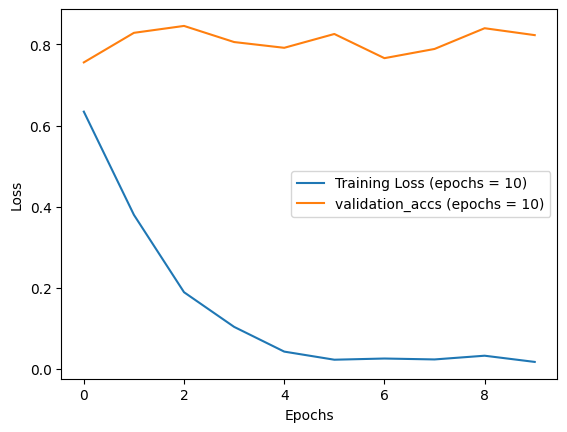

In [41]:
# for i, epoch in enumerate(training_epochs,):
plt.plot(learning_curve[1]['epochs'], learning_curve[1]['train_losses'], label=f'Training Loss (epochs = {epoch})')
plt.plot(learning_curve[1]['epochs'], learning_curve[1]['validation_accs'], label=f'validation_accs (epochs = {epoch})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

- - - -
**<font color='red'>Task 6:</font> Compare different learning rates with 0.1, 1e-3 and 1e-5. You can try with your own settings and find the best learning rate.**
- - - -
Learning rate needs to be chosen carefully in order for gradient descent to work properply. How quickly we update the parameters of our models is determined by the learning rate. If we choose the learning rate to be too small, we may need a lot more iteration to converge to the optimal values. If we choose the learning rate to be too big, we may go past our optimal values. So, it is important to choose the learning rate carefully.


In [42]:
def range_learning_rates(start, stop, step):
    result = []
    while start < stop:
        result.append(start)
        start *= step  # Adjusted for multiplicative step
    return result


In [43]:
learning_rates2 = range_learning_rates(1e-12, 1e-6, 2)
learning_curve2 = {}

for i, lr in enumerate(learning_rates2,1):
    model = initialize_model()
    print('Learning rate:', lr)
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve2[i] = train_model(model, train_data_loader, val_data_loader, 5, lr, verbose=True)
    print('Training complete!')

Learning rate: 1e-12


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.707 | Train Acc: 48.84% | Val. Loss: 0.708 | Val. Acc: 46.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.699 | Train Acc: 51.88% | Val. Loss: 0.708 | Val. Acc: 46.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.708 | Train Acc: 48.93% | Val. Loss: 0.708 | Val. Acc: 46.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.699 | Train Acc: 49.20% | Val. Loss: 0.708 | Val. Acc: 46.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.709 | Train Acc: 48.48% | Val. Loss: 0.708 | Val. Acc: 46.59% |
Test Loss: 0.700 | Test Acc: 50.94% |

Training complete!
Learning rate: 2e-12


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.705 | Train Acc: 52.14% | Val. Loss: 0.705 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.710 | Train Acc: 49.82% | Val. Loss: 0.705 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.694 | Train Acc: 53.30% | Val. Loss: 0.705 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.710 | Train Acc: 49.73% | Val. Loss: 0.705 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.708 | Train Acc: 51.07% | Val. Loss: 0.705 | Val. Acc: 46.31% |
Test Loss: 0.694 | Test Acc: 49.44% |

Training complete!
Learning rate: 4e-12


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.733 | Train Acc: 46.88% | Val. Loss: 0.717 | Val. Acc: 52.08% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.718 | Train Acc: 49.91% | Val. Loss: 0.717 | Val. Acc: 52.08% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.726 | Train Acc: 47.77% | Val. Loss: 0.717 | Val. Acc: 52.08% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.721 | Train Acc: 48.21% | Val. Loss: 0.717 | Val. Acc: 52.08% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.727 | Train Acc: 47.23% | Val. Loss: 0.717 | Val. Acc: 52.08% |
Test Loss: 0.711 | Test Acc: 50.49% |

Training complete!
Learning rate: 8e-12


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.698 | Train Acc: 51.25% | Val. Loss: 0.700 | Val. Acc: 46.40% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.707 | Train Acc: 49.82% | Val. Loss: 0.700 | Val. Acc: 46.40% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.705 | Train Acc: 49.55% | Val. Loss: 0.700 | Val. Acc: 46.40% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.709 | Train Acc: 49.20% | Val. Loss: 0.700 | Val. Acc: 46.40% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.707 | Train Acc: 48.30% | Val. Loss: 0.700 | Val. Acc: 46.40% |
Test Loss: 0.693 | Test Acc: 52.05% |

Training complete!
Learning rate: 1.6e-11


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.715 | Train Acc: 50.18% | Val. Loss: 0.706 | Val. Acc: 41.38% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.705 | Train Acc: 51.88% | Val. Loss: 0.706 | Val. Acc: 41.38% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.708 | Train Acc: 50.80% | Val. Loss: 0.706 | Val. Acc: 41.38% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.708 | Train Acc: 47.95% | Val. Loss: 0.706 | Val. Acc: 41.38% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.709 | Train Acc: 50.36% | Val. Loss: 0.706 | Val. Acc: 41.38% |
Test Loss: 0.699 | Test Acc: 47.50% |

Training complete!
Learning rate: 3.2e-11


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.713 | Train Acc: 50.18% | Val. Loss: 0.687 | Val. Acc: 54.83% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.709 | Train Acc: 50.89% | Val. Loss: 0.687 | Val. Acc: 54.83% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.702 | Train Acc: 52.14% | Val. Loss: 0.687 | Val. Acc: 54.83% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.705 | Train Acc: 51.25% | Val. Loss: 0.687 | Val. Acc: 54.83% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.706 | Train Acc: 50.80% | Val. Loss: 0.687 | Val. Acc: 54.83% |
Test Loss: 0.696 | Test Acc: 50.00% |

Training complete!
Learning rate: 6.4e-11


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.707 | Train Acc: 49.55% | Val. Loss: 0.707 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.714 | Train Acc: 47.14% | Val. Loss: 0.707 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.714 | Train Acc: 48.21% | Val. Loss: 0.707 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.712 | Train Acc: 49.64% | Val. Loss: 0.707 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.700 | Train Acc: 54.29% | Val. Loss: 0.707 | Val. Acc: 46.31% |
Test Loss: 0.698 | Test Acc: 49.44% |

Training complete!
Learning rate: 1.28e-10


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.710 | Train Acc: 51.79% | Val. Loss: 0.695 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.710 | Train Acc: 51.61% | Val. Loss: 0.695 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.710 | Train Acc: 51.52% | Val. Loss: 0.695 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.719 | Train Acc: 50.18% | Val. Loss: 0.695 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.714 | Train Acc: 50.18% | Val. Loss: 0.695 | Val. Acc: 53.69% |
Test Loss: 0.706 | Test Acc: 50.24% |

Training complete!
Learning rate: 2.56e-10


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.770 | Train Acc: 50.45% | Val. Loss: 0.729 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.766 | Train Acc: 50.18% | Val. Loss: 0.729 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.770 | Train Acc: 50.09% | Val. Loss: 0.729 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.773 | Train Acc: 50.18% | Val. Loss: 0.729 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.762 | Train Acc: 50.27% | Val. Loss: 0.729 | Val. Acc: 53.69% |
Test Loss: 0.754 | Test Acc: 50.24% |

Training complete!
Learning rate: 5.12e-10


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.724 | Train Acc: 47.68% | Val. Loss: 0.726 | Val. Acc: 43.18% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.717 | Train Acc: 48.84% | Val. Loss: 0.726 | Val. Acc: 43.18% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.723 | Train Acc: 47.05% | Val. Loss: 0.726 | Val. Acc: 43.18% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.726 | Train Acc: 48.75% | Val. Loss: 0.726 | Val. Acc: 43.18% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.721 | Train Acc: 47.95% | Val. Loss: 0.725 | Val. Acc: 43.18% |
Test Loss: 0.705 | Test Acc: 49.76% |

Training complete!
Learning rate: 1.024e-09


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.803 | Train Acc: 49.64% | Val. Loss: 0.850 | Val. Acc: 45.74% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.783 | Train Acc: 49.38% | Val. Loss: 0.849 | Val. Acc: 45.74% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.790 | Train Acc: 49.64% | Val. Loss: 0.848 | Val. Acc: 45.74% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.794 | Train Acc: 50.45% | Val. Loss: 0.848 | Val. Acc: 45.74% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.797 | Train Acc: 48.84% | Val. Loss: 0.847 | Val. Acc: 45.74% |
Test Loss: 0.807 | Test Acc: 49.44% |

Training complete!
Learning rate: 2.048e-09


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.763 | Train Acc: 49.73% | Val. Loss: 0.792 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.761 | Train Acc: 48.75% | Val. Loss: 0.791 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.763 | Train Acc: 48.66% | Val. Loss: 0.790 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.760 | Train Acc: 49.20% | Val. Loss: 0.789 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.764 | Train Acc: 49.46% | Val. Loss: 0.788 | Val. Acc: 46.31% |
Test Loss: 0.754 | Test Acc: 49.44% |

Training complete!
Learning rate: 4.096e-09


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.714 | Train Acc: 47.50% | Val. Loss: 0.704 | Val. Acc: 53.12% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.718 | Train Acc: 46.88% | Val. Loss: 0.704 | Val. Acc: 53.12% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.713 | Train Acc: 49.82% | Val. Loss: 0.704 | Val. Acc: 53.12% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.716 | Train Acc: 48.57% | Val. Loss: 0.704 | Val. Acc: 53.12% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.715 | Train Acc: 48.21% | Val. Loss: 0.704 | Val. Acc: 53.12% |
Test Loss: 0.704 | Test Acc: 49.62% |

Training complete!
Learning rate: 8.192e-09


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.711 | Train Acc: 52.14% | Val. Loss: 0.696 | Val. Acc: 53.98% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.709 | Train Acc: 51.61% | Val. Loss: 0.695 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.717 | Train Acc: 49.20% | Val. Loss: 0.695 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.709 | Train Acc: 51.34% | Val. Loss: 0.694 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.713 | Train Acc: 50.18% | Val. Loss: 0.694 | Val. Acc: 53.69% |
Test Loss: 0.703 | Test Acc: 50.56% |

Training complete!
Learning rate: 1.6384e-08


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.699 | Train Acc: 50.62% | Val. Loss: 0.688 | Val. Acc: 56.16% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.697 | Train Acc: 53.75% | Val. Loss: 0.688 | Val. Acc: 55.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.700 | Train Acc: 49.82% | Val. Loss: 0.687 | Val. Acc: 56.16% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.697 | Train Acc: 50.89% | Val. Loss: 0.687 | Val. Acc: 57.29% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.695 | Train Acc: 53.39% | Val. Loss: 0.686 | Val. Acc: 57.29% |
Test Loss: 0.689 | Test Acc: 56.35% |

Training complete!
Learning rate: 3.2768e-08


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.716 | Train Acc: 50.80% | Val. Loss: 0.683 | Val. Acc: 55.40% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.704 | Train Acc: 54.02% | Val. Loss: 0.677 | Val. Acc: 57.10% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.712 | Train Acc: 49.55% | Val. Loss: 0.673 | Val. Acc: 58.81% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.695 | Train Acc: 52.59% | Val. Loss: 0.670 | Val. Acc: 59.09% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.707 | Train Acc: 50.62% | Val. Loss: 0.668 | Val. Acc: 61.36% |
Test Loss: 0.688 | Test Acc: 56.94% |

Training complete!
Learning rate: 6.5536e-08


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.769 | Train Acc: 49.20% | Val. Loss: 0.736 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.748 | Train Acc: 49.55% | Val. Loss: 0.725 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.738 | Train Acc: 49.82% | Val. Loss: 0.718 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.737 | Train Acc: 49.29% | Val. Loss: 0.712 | Val. Acc: 53.41% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.723 | Train Acc: 50.09% | Val. Loss: 0.707 | Val. Acc: 53.41% |
Test Loss: 0.714 | Test Acc: 50.56% |

Training complete!
Learning rate: 1.31072e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.713 | Train Acc: 49.02% | Val. Loss: 0.688 | Val. Acc: 53.12% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.702 | Train Acc: 51.88% | Val. Loss: 0.679 | Val. Acc: 58.24% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.687 | Train Acc: 53.84% | Val. Loss: 0.672 | Val. Acc: 61.93% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.686 | Train Acc: 55.09% | Val. Loss: 0.663 | Val. Acc: 63.92% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.682 | Train Acc: 57.68% | Val. Loss: 0.656 | Val. Acc: 68.56% |
Test Loss: 0.663 | Test Acc: 62.12% |

Training complete!
Learning rate: 2.62144e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.707 | Train Acc: 51.52% | Val. Loss: 0.676 | Val. Acc: 67.42% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.683 | Train Acc: 55.98% | Val. Loss: 0.655 | Val. Acc: 75.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.671 | Train Acc: 59.91% | Val. Loss: 0.641 | Val. Acc: 75.57% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.670 | Train Acc: 58.30% | Val. Loss: 0.627 | Val. Acc: 76.42% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.658 | Train Acc: 61.96% | Val. Loss: 0.615 | Val. Acc: 76.14% |
Test Loss: 0.632 | Test Acc: 71.53% |

Training complete!
Learning rate: 5.24288e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.699 | Train Acc: 52.32% | Val. Loss: 0.643 | Val. Acc: 77.75% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.658 | Train Acc: 63.21% | Val. Loss: 0.591 | Val. Acc: 82.10% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.601 | Train Acc: 68.39% | Val. Loss: 0.521 | Val. Acc: 81.44% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.542 | Train Acc: 76.43% | Val. Loss: 0.472 | Val. Acc: 81.06% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.505 | Train Acc: 79.02% | Val. Loss: 0.445 | Val. Acc: 81.72% |
Test Loss: 0.474 | Test Acc: 81.01% |

Training complete!


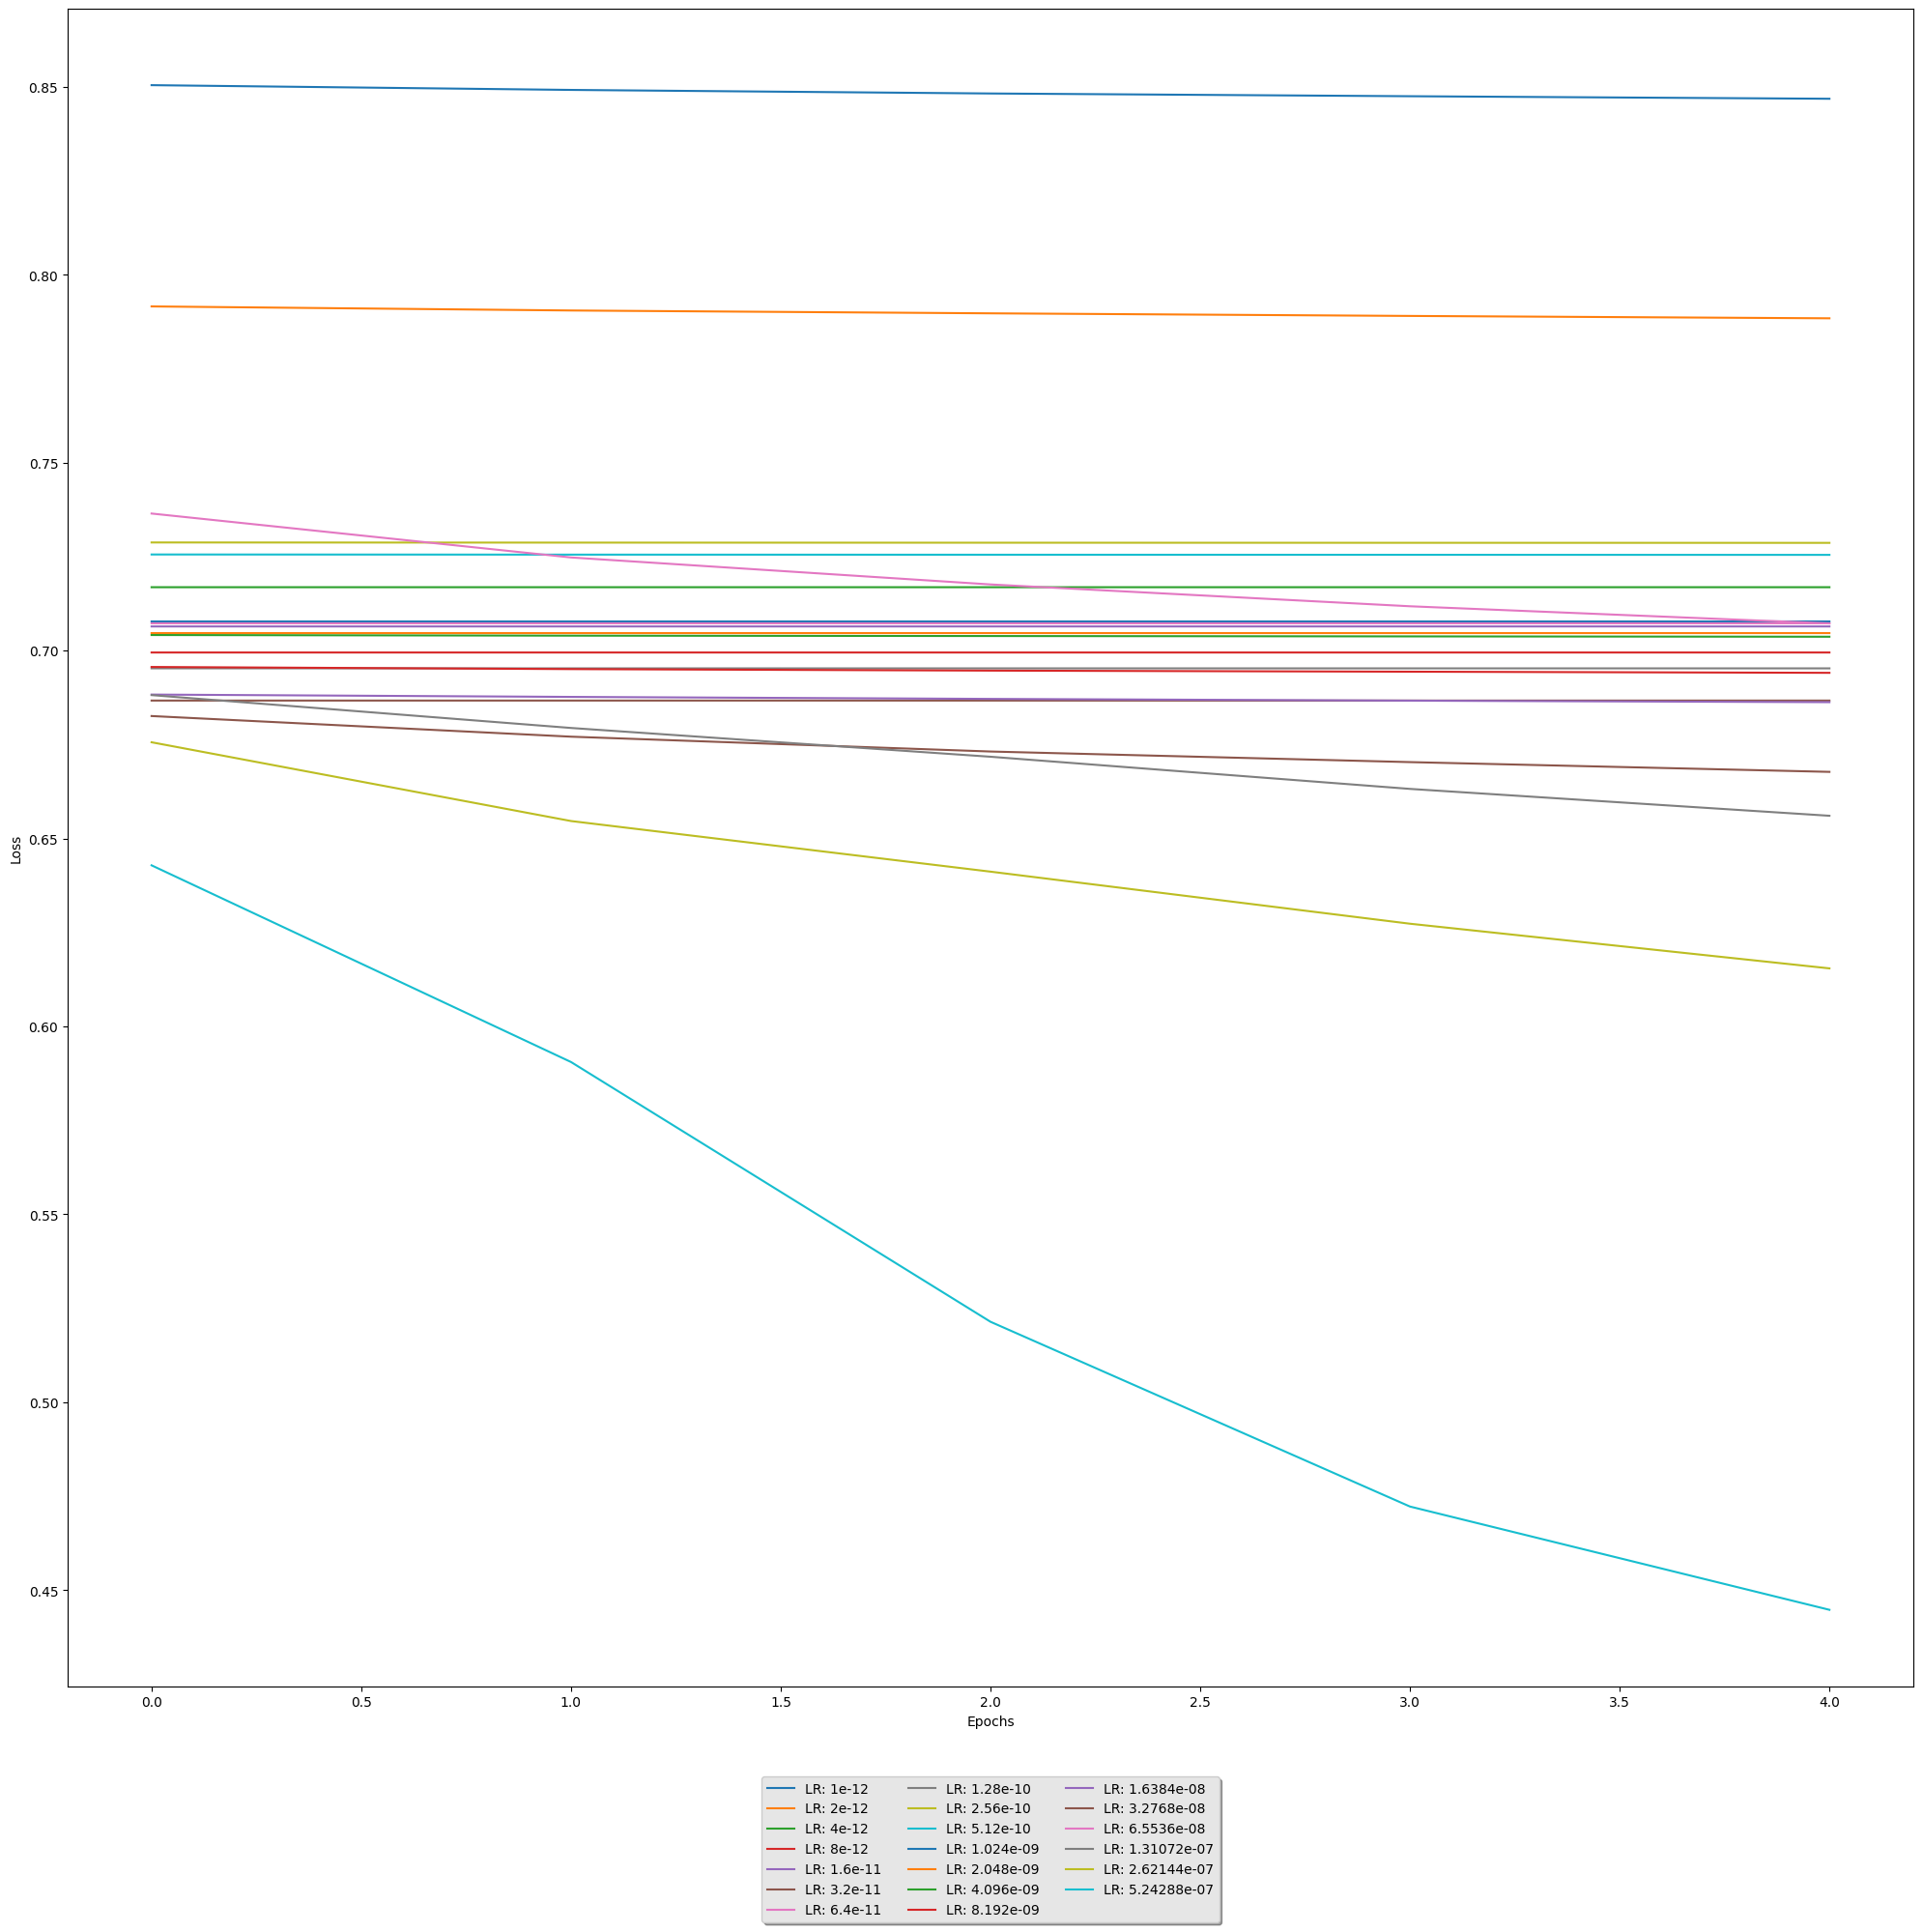

In [44]:
plt.figure(figsize=(20,20))

for i, lr in enumerate(learning_rates2, 1):
    plt.plot(learning_curve2[i]["epochs"], np.squeeze(learning_curve2[i]["validation_losses"]), label=f'LR: {learning_curve2[i]["learning_rate"]}')

plt.ylabel('Loss')
plt.xlabel('Epochs')

# Adjust legend position
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3)
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Adjust layout
plt.tight_layout()

plt.show()

In [46]:
learning_rates3 = range_learning_rates(1e-07, 1e-06, 1.5)
len(learning_rates3)


learning_curve3 = {}

for i, lr in enumerate(learning_rates3,1):
    model = initialize_model()
    print('Learning rate:', lr)
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve3[i] = train_model(model, train_data_loader, val_data_loader, 5, lr, verbose=True)
    print('Training complete!')

Learning rate: 1e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.718 | Train Acc: 50.27% | Val. Loss: 0.716 | Val. Acc: 44.03% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.705 | Train Acc: 50.89% | Val. Loss: 0.702 | Val. Acc: 46.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.693 | Train Acc: 52.32% | Val. Loss: 0.693 | Val. Acc: 48.39% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.693 | Train Acc: 54.46% | Val. Loss: 0.687 | Val. Acc: 52.65% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.682 | Train Acc: 55.98% | Val. Loss: 0.681 | Val. Acc: 57.77% |
Test Loss: 0.675 | Test Acc: 61.84% |

Training complete!
Learning rate: 1.5e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.720 | Train Acc: 50.36% | Val. Loss: 0.689 | Val. Acc: 57.10% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.696 | Train Acc: 51.07% | Val. Loss: 0.674 | Val. Acc: 59.19% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.693 | Train Acc: 52.32% | Val. Loss: 0.660 | Val. Acc: 59.56% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.668 | Train Acc: 59.20% | Val. Loss: 0.644 | Val. Acc: 66.76% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.660 | Train Acc: 60.54% | Val. Loss: 0.634 | Val. Acc: 68.66% |
Test Loss: 0.639 | Test Acc: 66.18% |

Training complete!
Learning rate: 2.25e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.699 | Train Acc: 51.79% | Val. Loss: 0.681 | Val. Acc: 61.65% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.682 | Train Acc: 56.07% | Val. Loss: 0.666 | Val. Acc: 65.81% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.676 | Train Acc: 58.30% | Val. Loss: 0.654 | Val. Acc: 71.97% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.664 | Train Acc: 61.79% | Val. Loss: 0.641 | Val. Acc: 71.59% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.654 | Train Acc: 63.04% | Val. Loss: 0.623 | Val. Acc: 71.88% |
Test Loss: 0.634 | Test Acc: 67.99% |

Training complete!
Learning rate: 3.375e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.691 | Train Acc: 54.11% | Val. Loss: 0.661 | Val. Acc: 71.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.669 | Train Acc: 59.46% | Val. Loss: 0.642 | Val. Acc: 74.81% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.659 | Train Acc: 58.75% | Val. Loss: 0.613 | Val. Acc: 76.99% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.632 | Train Acc: 65.62% | Val. Loss: 0.587 | Val. Acc: 75.76% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.599 | Train Acc: 71.34% | Val. Loss: 0.559 | Val. Acc: 76.89% |
Test Loss: 0.577 | Test Acc: 74.58% |

Training complete!
Learning rate: 5.0625e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.695 | Train Acc: 52.77% | Val. Loss: 0.669 | Val. Acc: 67.33% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.694 | Train Acc: 53.12% | Val. Loss: 0.652 | Val. Acc: 73.30% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.665 | Train Acc: 59.46% | Val. Loss: 0.632 | Val. Acc: 72.92% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.648 | Train Acc: 64.38% | Val. Loss: 0.611 | Val. Acc: 74.62% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.623 | Train Acc: 68.30% | Val. Loss: 0.583 | Val. Acc: 77.27% |
Test Loss: 0.593 | Test Acc: 75.14% |

Training complete!
Learning rate: 7.59375e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.693 | Train Acc: 55.09% | Val. Loss: 0.624 | Val. Acc: 69.79% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.632 | Train Acc: 67.50% | Val. Loss: 0.573 | Val. Acc: 73.11% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.565 | Train Acc: 74.73% | Val. Loss: 0.532 | Val. Acc: 76.61% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.514 | Train Acc: 78.84% | Val. Loss: 0.511 | Val. Acc: 75.76% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.468 | Train Acc: 81.34% | Val. Loss: 0.492 | Val. Acc: 76.89% |
Test Loss: 0.484 | Test Acc: 78.58% |

Training complete!


In [48]:
learning_rates3

[1e-07, 1.5e-07, 2.25e-07, 3.375e-07, 5.0625e-07, 7.59375e-07]

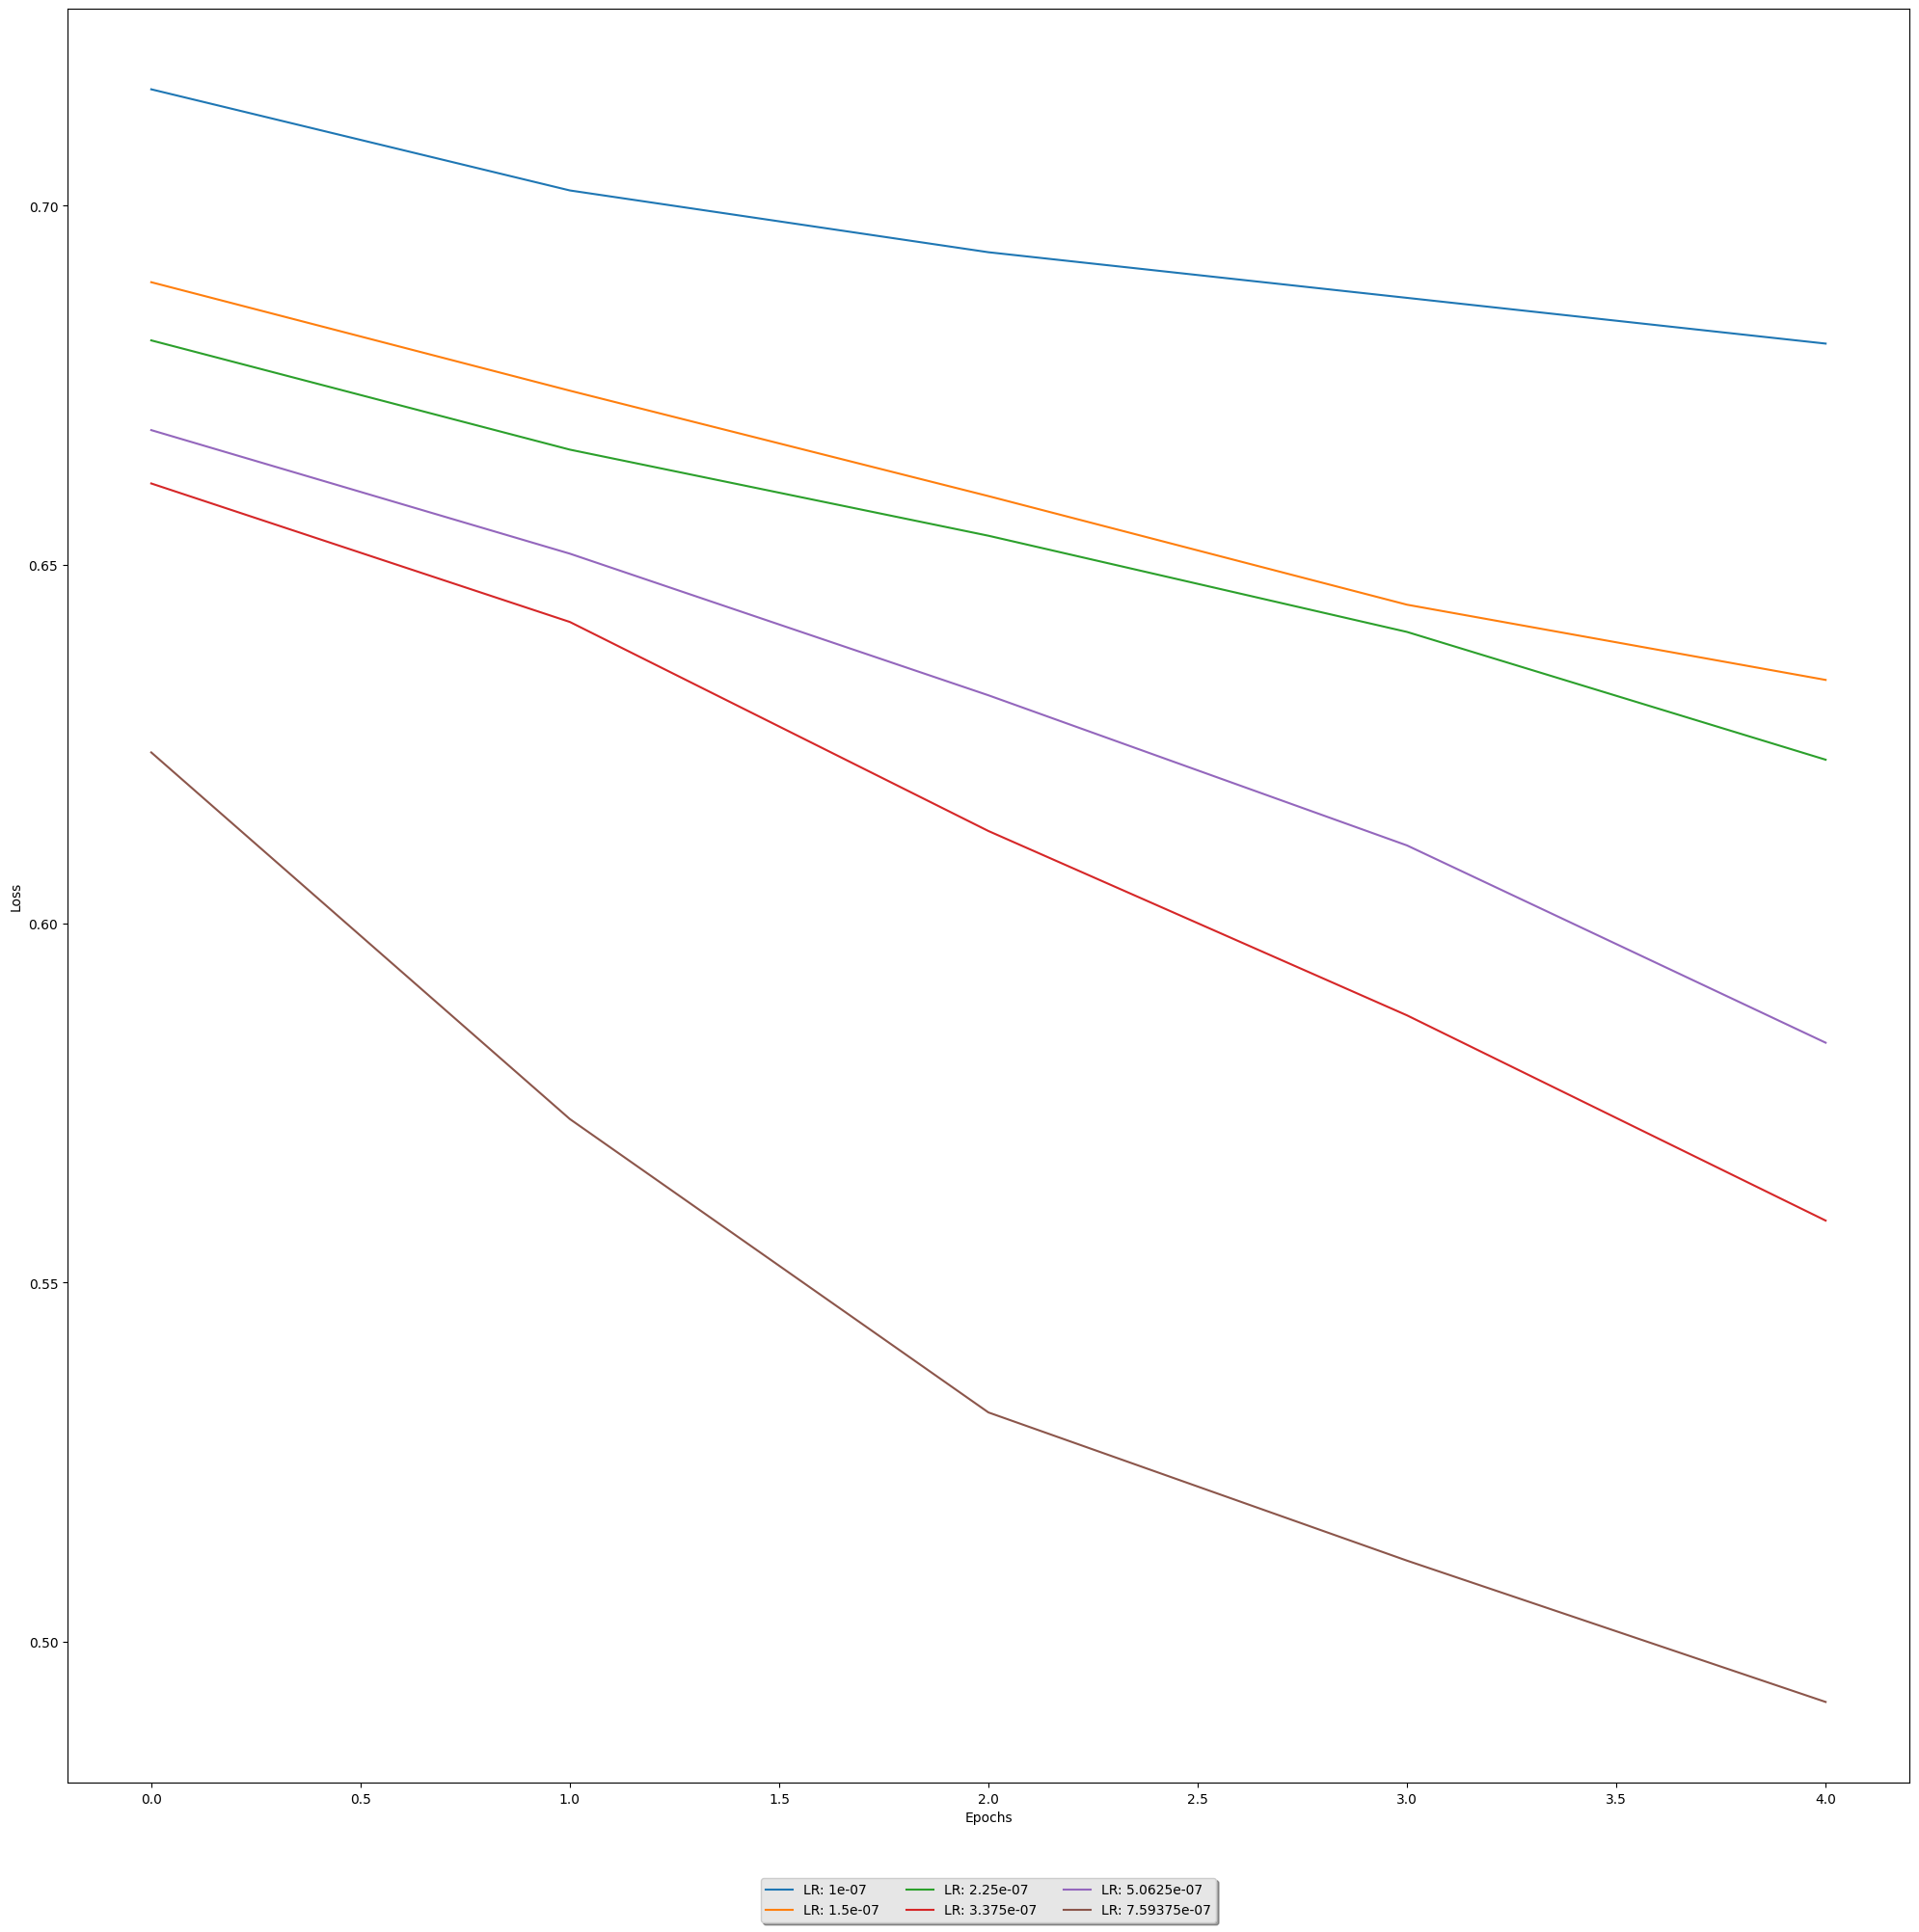

In [47]:
plt.figure(figsize=(20,20))

for i, lr in enumerate(learning_rates3, 1):
    plt.plot(learning_curve2[i]["epochs"], np.squeeze(learning_curve3[i]["validation_losses"]), label=f'LR: {learning_curve3[i]["learning_rate"]}')

plt.ylabel('Loss')
plt.xlabel('Epochs')

# Adjust legend position
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3)
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Adjust layout
plt.tight_layout()

plt.show()

In [49]:
learning_rates4 = [1e-06, 1e-05, 0.0001, 0.001, 0.01]

learning_curve4 = {}

for i, lr in enumerate(learning_rates4,1):
    model = initialize_model()
    print('Learning rate:', lr)
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve4[i] = train_model(model, train_data_loader, val_data_loader, 5, lr, verbose=True)
    print('Training complete!')

Learning rate: 1e-06


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.680 | Train Acc: 56.52% | Val. Loss: 0.614 | Val. Acc: 72.35% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.598 | Train Acc: 69.11% | Val. Loss: 0.509 | Val. Acc: 77.18% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.514 | Train Acc: 76.16% | Val. Loss: 0.485 | Val. Acc: 77.56% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.449 | Train Acc: 80.80% | Val. Loss: 0.483 | Val. Acc: 77.56% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.410 | Train Acc: 83.04% | Val. Loss: 0.474 | Val. Acc: 77.27% |
Test Loss: 0.462 | Test Acc: 78.12% |

Training complete!
Learning rate: 1e-05


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.615 | Train Acc: 64.91% | Val. Loss: 0.420 | Val. Acc: 81.91% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.276 | Train Acc: 88.75% | Val. Loss: 0.459 | Val. Acc: 83.33% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.112 | Train Acc: 97.23% | Val. Loss: 0.533 | Val. Acc: 83.52% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.060 | Train Acc: 98.57% | Val. Loss: 0.605 | Val. Acc: 84.09% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.037 | Train Acc: 99.20% | Val. Loss: 0.631 | Val. Acc: 82.86% |
Test Loss: 0.588 | Test Acc: 86.25% |

Training complete!
Learning rate: 0.0001


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.740 | Train Acc: 46.43% | Val. Loss: 0.690 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.714 | Train Acc: 49.38% | Val. Loss: 0.692 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.709 | Train Acc: 48.30% | Val. Loss: 0.690 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.700 | Train Acc: 50.98% | Val. Loss: 0.690 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.702 | Train Acc: 48.39% | Val. Loss: 0.691 | Val. Acc: 53.69% |
Test Loss: 0.698 | Test Acc: 50.24% |

Training complete!
Learning rate: 0.001


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.495 | Train Acc: 53.84% | Val. Loss: 0.777 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.877 | Train Acc: 50.27% | Val. Loss: 0.915 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.839 | Train Acc: 51.61% | Val. Loss: 0.932 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.848 | Train Acc: 47.59% | Val. Loss: 0.873 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.802 | Train Acc: 50.80% | Val. Loss: 0.861 | Val. Acc: 53.69% |
Test Loss: 0.908 | Test Acc: 50.24% |

Training complete!
Learning rate: 0.01


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 6.649 | Train Acc: 51.96% | Val. Loss: 3.581 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 3.349 | Train Acc: 50.62% | Val. Loss: 2.041 | Val. Acc: 53.69% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 2.121 | Train Acc: 52.95% | Val. Loss: 0.712 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 2.160 | Train Acc: 50.98% | Val. Loss: 1.134 | Val. Acc: 46.31% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.786 | Train Acc: 51.61% | Val. Loss: 0.691 | Val. Acc: 53.69% |
Test Loss: 0.694 | Test Acc: 50.24% |

Training complete!


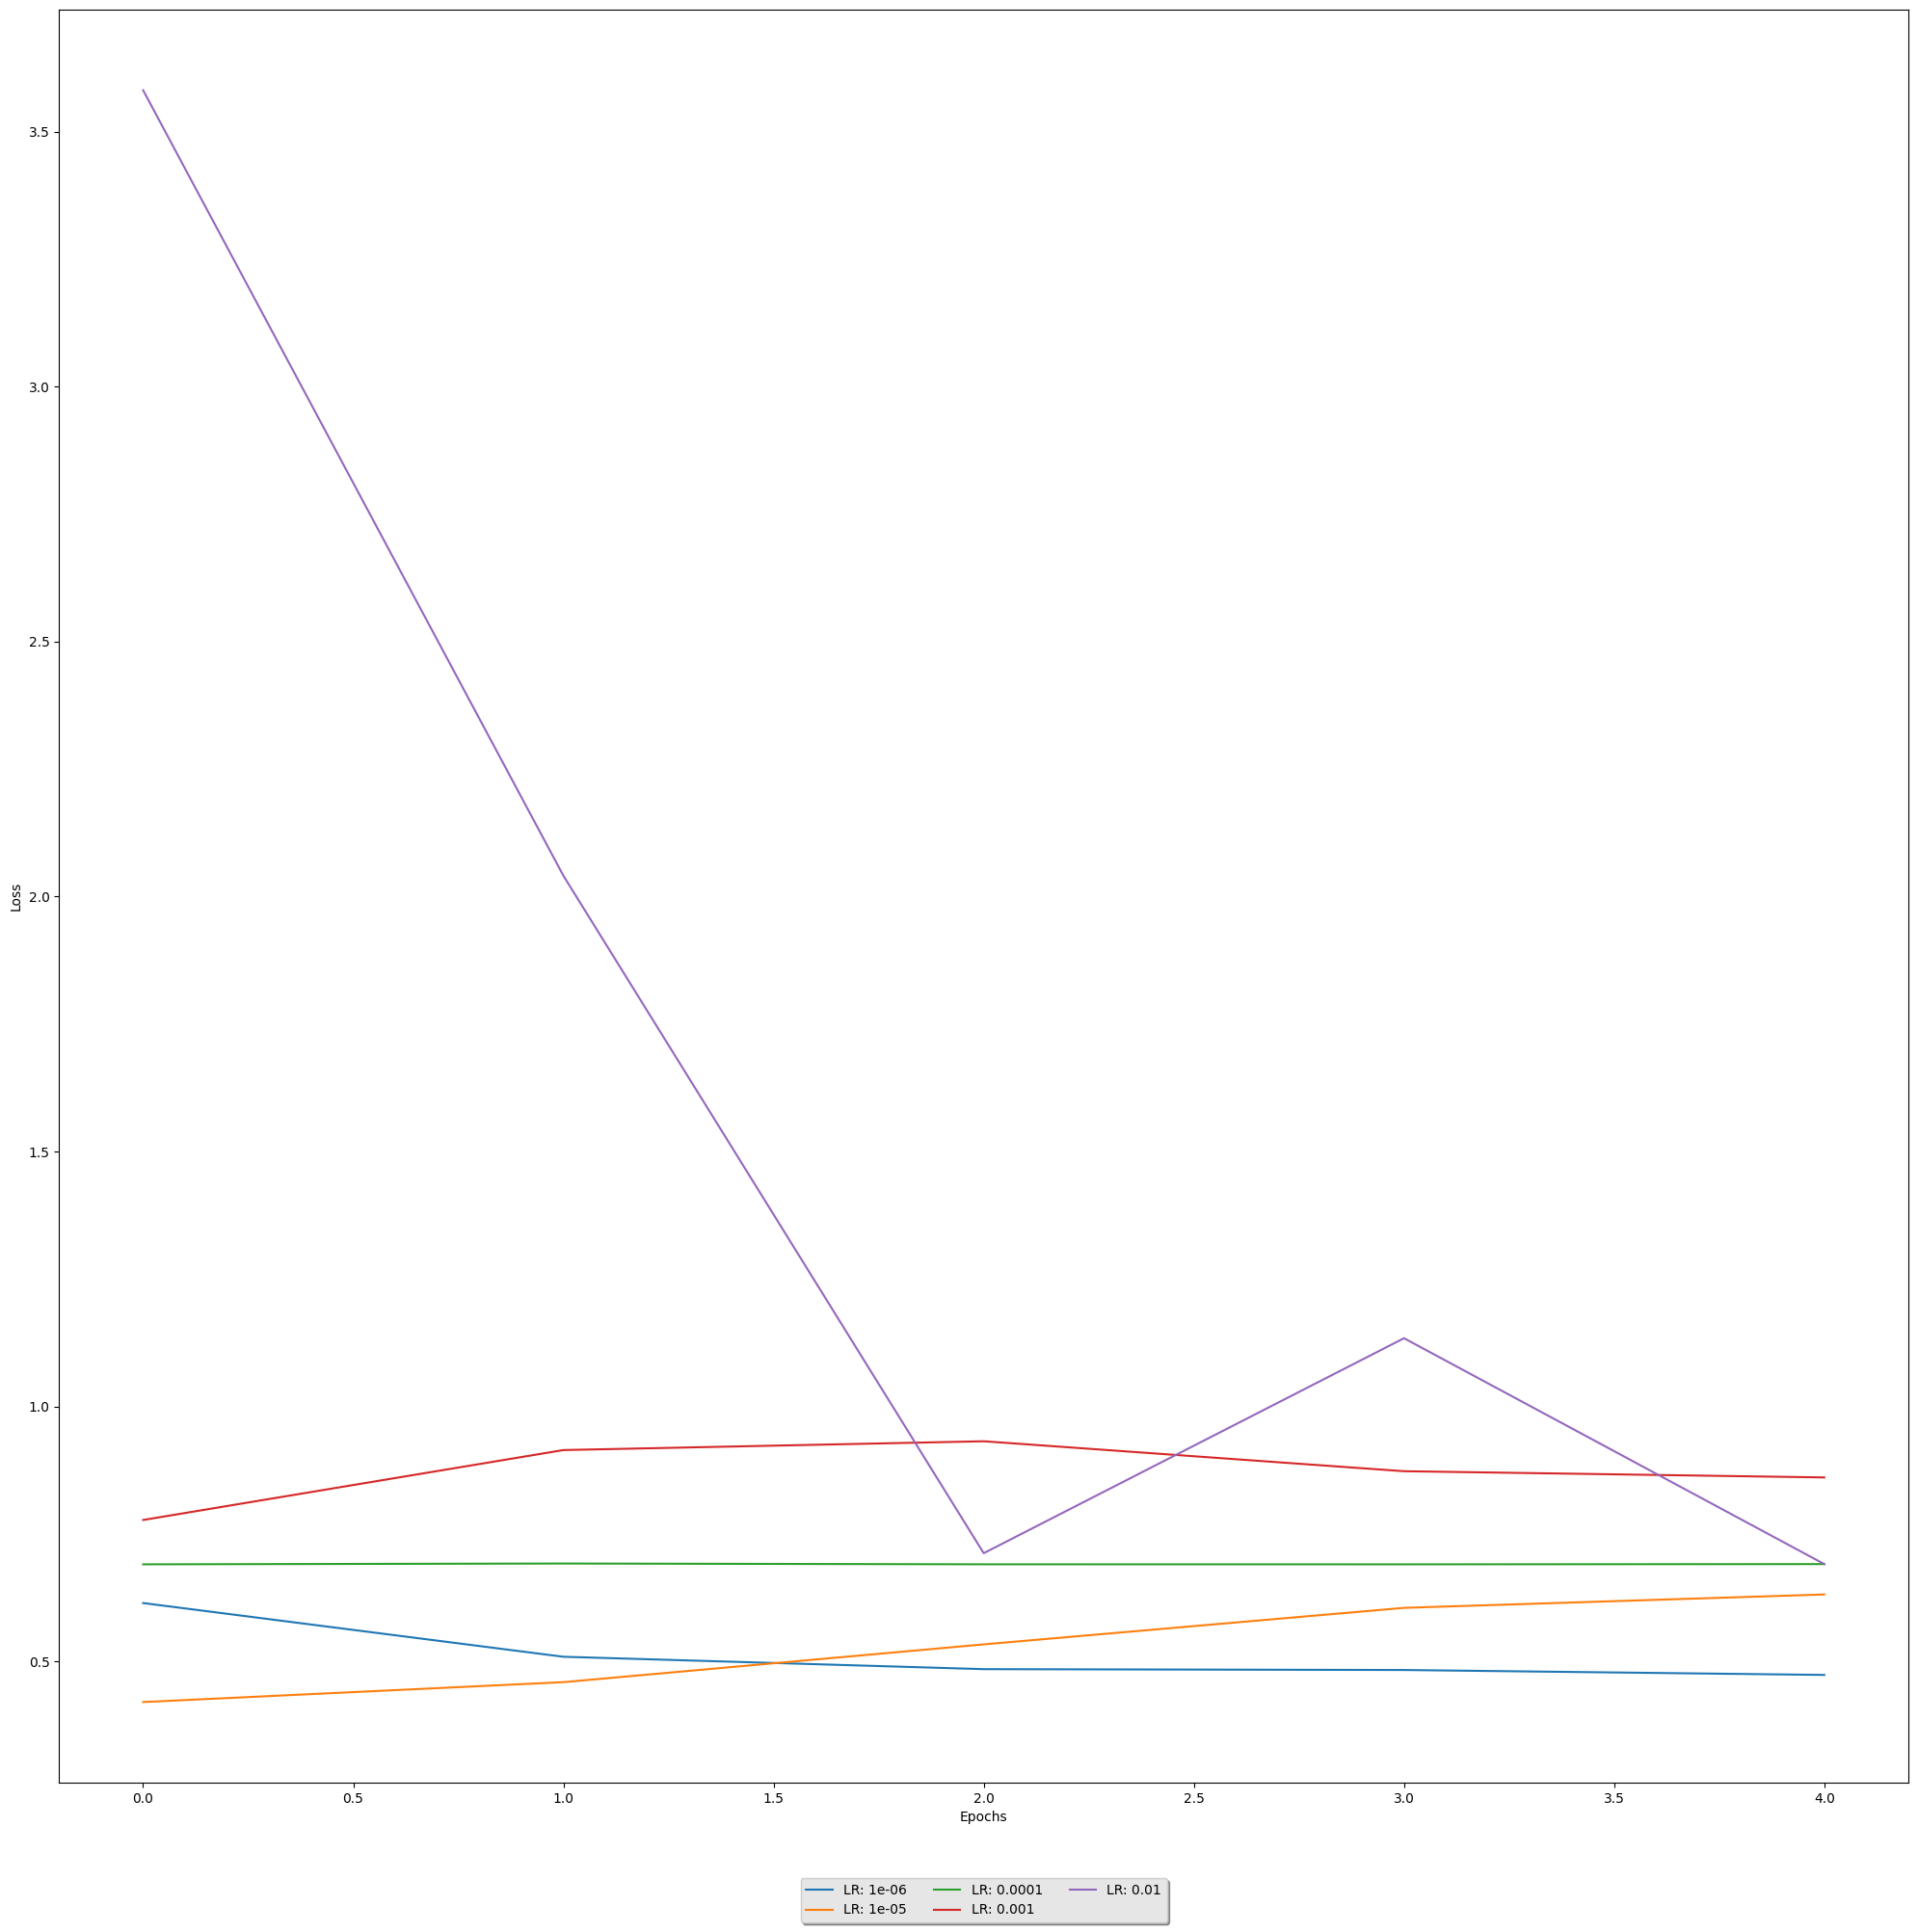

In [50]:
plt.figure(figsize=(20,20))

for i, lr in enumerate(learning_rates4, 1):
    plt.plot(learning_curve4[i]["epochs"], np.squeeze(learning_curve4[i]["validation_losses"]), label=f'LR: {learning_curve4[i]["learning_rate"]}')

plt.ylabel('Loss')
plt.xlabel('Epochs')

# Adjust legend position
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3)
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Adjust layout
plt.tight_layout()

plt.show()

In [52]:
# # which aqua line was the good one? 
# i = 10
# plt.plot(learning_curve2[i]["epochs"], np.squeeze(learning_curve2[i]["validation_losses"]), label=f'LR: {learning_curve2[i]["learning_rate"]}')
# i = 20
# plt.plot(learning_curve2[i]["epochs"], np.squeeze(learning_curve2[i]["validation_losses"]), label=f'LR: {learning_curve2[i]["learning_rate"]}')

# plt.ylabel('Loss')
# plt.xlabel('Epochs')

# # Adjust legend position
# legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3)
# frame = legend.get_frame()
# frame.set_facecolor('0.90')

# # Adjust layout
# plt.tight_layout()

# plt.show()

optimal_learning_rate1 = 5.24288e-07
optimal_learning_rate2 = 1e-06

In [53]:
# let us rexamine the epoch optimization with our optimal learning rate. 
training_epochs = [20]
learning_curve = {}

for i, epoch in enumerate(training_epochs,1):
    print(f'Training for {epoch} epochs')
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve[i] = train_model(model, train_data_loader, val_data_loader, epoch,  optimal_learning_rate2, verbose=True)
    print('training complete!')


Training for 20 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.693 | Train Acc: 53.75% | Val. Loss: 0.623 | Val. Acc: 74.62% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.611 | Train Acc: 67.59% | Val. Loss: 0.523 | Val. Acc: 78.79% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.523 | Train Acc: 76.96% | Val. Loss: 0.465 | Val. Acc: 79.64% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.443 | Train Acc: 81.16% | Val. Loss: 0.431 | Val. Acc: 79.92% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.396 | Train Acc: 84.29% | Val. Loss: 0.414 | Val. Acc: 81.44% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.350 | Train Acc: 87.23% | Val. Loss: 0.412 | Val. Acc: 80.87% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.324 | Train Acc: 87.95% | Val. Loss: 0.403 | Val. Acc: 82.01% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.290 | Train Acc: 90.18% | Val. Loss: 0.403 | Val. Acc: 82.29% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.274 | Train Acc: 90.80% | Val. Loss: 0.395 | Val. Acc: 83.43% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 0.244 | Train Acc: 92.77% | Val. Loss: 0.409 | Val. Acc: 82.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 0.233 | Train Acc: 92.41% | Val. Loss: 0.399 | Val. Acc: 83.71% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 0.220 | Train Acc: 93.39% | Val. Loss: 0.390 | Val. Acc: 83.71% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 0.195 | Train Acc: 93.93% | Val. Loss: 0.402 | Val. Acc: 85.80% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 0.184 | Train Acc: 94.64% | Val. Loss: 0.402 | Val. Acc: 84.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 0.168 | Train Acc: 95.71% | Val. Loss: 0.400 | Val. Acc: 84.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 0.167 | Train Acc: 95.71% | Val. Loss: 0.403 | Val. Acc: 83.71% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 0.144 | Train Acc: 96.52% | Val. Loss: 0.401 | Val. Acc: 83.71% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 0.130 | Train Acc: 97.41% | Val. Loss: 0.404 | Val. Acc: 84.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 0.132 | Train Acc: 96.70% | Val. Loss: 0.411 | Val. Acc: 84.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 0.123 | Train Acc: 97.23% | Val. Loss: 0.411 | Val. Acc: 83.43% |
Test Loss: 0.427 | Test Acc: 83.12% |

training complete!


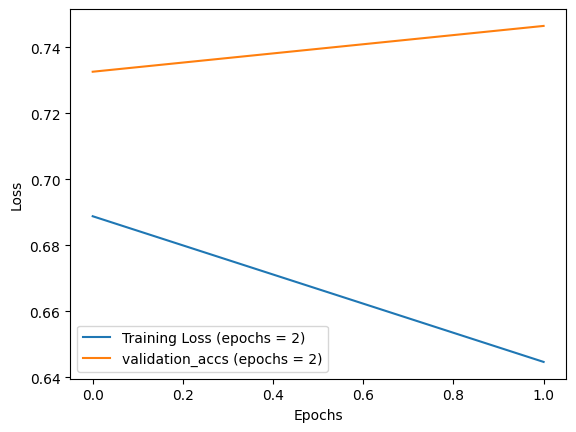

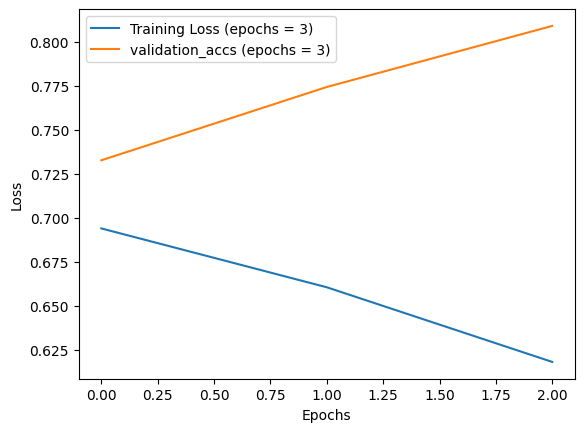

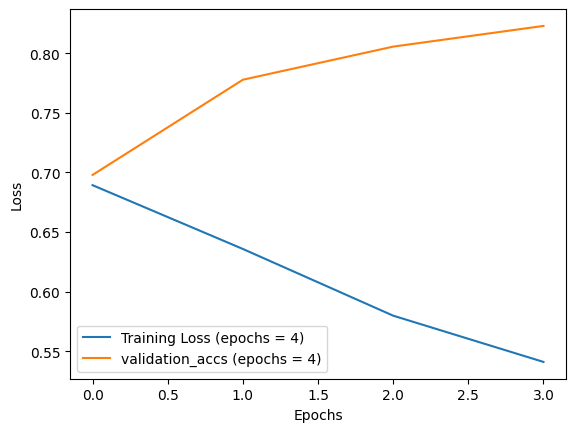

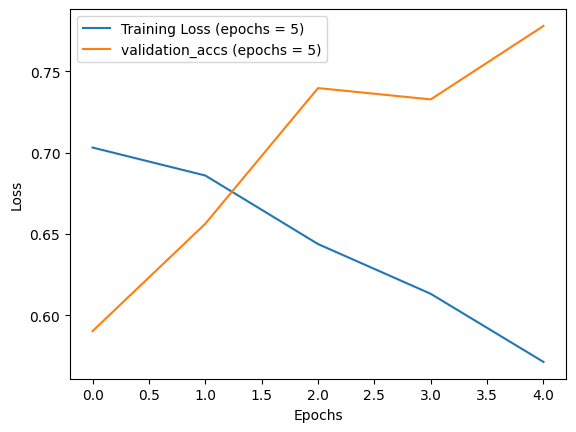

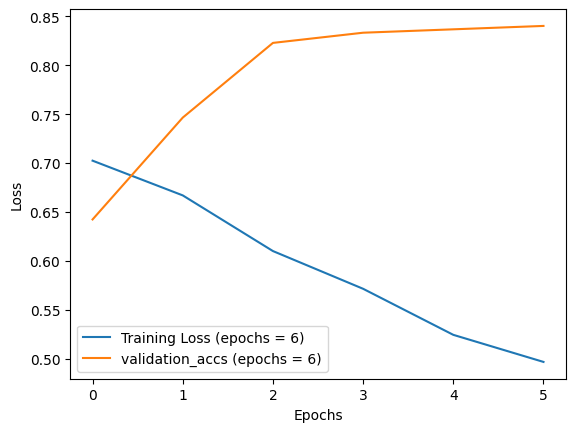

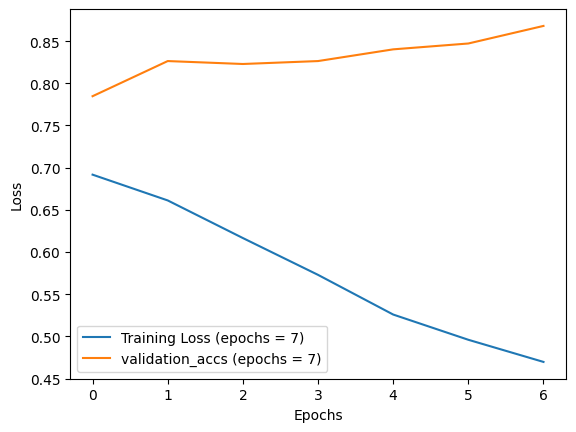

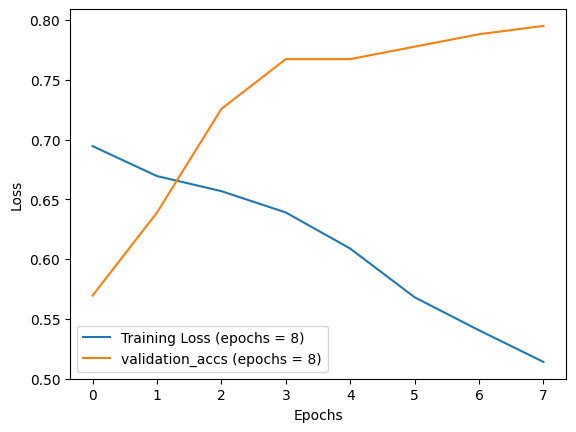

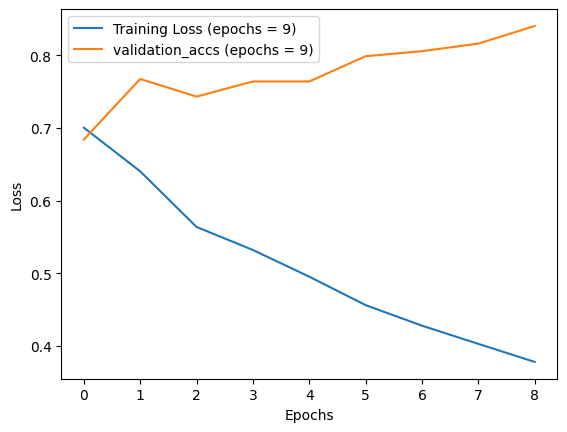

In [57]:
for i, epoch in enumerate(training_epochs,1):
    plt.plot(learning_curve[i]['epochs'], learning_curve[i]['train_losses'], label=f'Training Loss (epochs = {epoch})')
    plt.plot(learning_curve[i]['epochs'], learning_curve[i]['validation_accs'], label=f'validation_accs (epochs = {epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# We know that LR 5.24288e-07 was the best with the best loss decrease. 
# we know that epoch 3 was the best with the because looking the graphs the val loss tends to increase steadily at this epoch.

In [58]:
# Set the number of epochs
num_epochs = 50
# Set the desired learning rate
learning_rate = optimal_learning_rate

# Dictionary to store the learning curve
learning_curve = {}

# Initialize the model (Do this only once if you are not comparing multiple initializations)
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).to(device)
model = CyberbullyingDetecter(bert_model, Num_classes).to(device)

# Train the model
print(f'Training for {num_epochs} epochs with learning rate {learning_rate}')
learning_curve[learning_rate] = train_model(model, train_data_loader, val_data_loader, num_epochs, learning_rate, verbose=True)
print('Training complete!')


Training for 50 epochs with learning rate 5.24288e-07


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.693 | Train Acc: 54.02% | Val. Loss: 0.632 | Val. Acc: 77.08% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.642 | Train Acc: 63.66% | Val. Loss: 0.581 | Val. Acc: 80.90% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.599 | Train Acc: 70.45% | Val. Loss: 0.532 | Val. Acc: 81.60% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.563 | Train Acc: 74.29% | Val. Loss: 0.485 | Val. Acc: 83.33% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.523 | Train Acc: 77.05% | Val. Loss: 0.449 | Val. Acc: 83.68% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.471 | Train Acc: 81.43% | Val. Loss: 0.420 | Val. Acc: 85.42% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.452 | Train Acc: 82.23% | Val. Loss: 0.396 | Val. Acc: 86.11% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.417 | Train Acc: 84.38% | Val. Loss: 0.375 | Val. Acc: 87.15% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.396 | Train Acc: 86.34% | Val. Loss: 0.362 | Val. Acc: 87.15% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 0.368 | Train Acc: 86.96% | Val. Loss: 0.351 | Val. Acc: 87.85% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 0.348 | Train Acc: 88.66% | Val. Loss: 0.340 | Val. Acc: 87.85% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 0.343 | Train Acc: 88.04% | Val. Loss: 0.331 | Val. Acc: 87.50% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 0.325 | Train Acc: 89.82% | Val. Loss: 0.323 | Val. Acc: 87.85% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 0.308 | Train Acc: 89.91% | Val. Loss: 0.316 | Val. Acc: 88.19% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 0.299 | Train Acc: 90.45% | Val. Loss: 0.312 | Val. Acc: 88.54% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 0.282 | Train Acc: 90.62% | Val. Loss: 0.308 | Val. Acc: 88.19% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 0.282 | Train Acc: 91.07% | Val. Loss: 0.303 | Val. Acc: 89.24% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 0.266 | Train Acc: 91.61% | Val. Loss: 0.301 | Val. Acc: 88.89% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 0.253 | Train Acc: 92.50% | Val. Loss: 0.295 | Val. Acc: 89.24% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 0.251 | Train Acc: 92.59% | Val. Loss: 0.296 | Val. Acc: 88.89% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 0.235 | Train Acc: 93.84% | Val. Loss: 0.294 | Val. Acc: 89.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 0.233 | Train Acc: 92.59% | Val. Loss: 0.288 | Val. Acc: 89.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 0.232 | Train Acc: 93.21% | Val. Loss: 0.289 | Val. Acc: 89.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 0.218 | Train Acc: 93.93% | Val. Loss: 0.287 | Val. Acc: 89.93% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 0.208 | Train Acc: 94.38% | Val. Loss: 0.288 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 0.192 | Train Acc: 94.91% | Val. Loss: 0.289 | Val. Acc: 88.89% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 0.184 | Train Acc: 95.09% | Val. Loss: 0.286 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 0.182 | Train Acc: 95.36% | Val. Loss: 0.285 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 0.169 | Train Acc: 96.61% | Val. Loss: 0.285 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 0.175 | Train Acc: 95.27% | Val. Loss: 0.284 | Val. Acc: 90.62% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 0.172 | Train Acc: 95.45% | Val. Loss: 0.281 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 0.167 | Train Acc: 95.45% | Val. Loss: 0.281 | Val. Acc: 89.93% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 0.158 | Train Acc: 95.27% | Val. Loss: 0.278 | Val. Acc: 89.93% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 0.154 | Train Acc: 96.43% | Val. Loss: 0.280 | Val. Acc: 89.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 0.141 | Train Acc: 96.79% | Val. Loss: 0.280 | Val. Acc: 89.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 0.143 | Train Acc: 96.52% | Val. Loss: 0.280 | Val. Acc: 89.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 0.141 | Train Acc: 96.43% | Val. Loss: 0.283 | Val. Acc: 89.93% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 0.142 | Train Acc: 96.43% | Val. Loss: 0.281 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 0.122 | Train Acc: 97.77% | Val. Loss: 0.279 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 0.118 | Train Acc: 97.86% | Val. Loss: 0.280 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 0.121 | Train Acc: 97.23% | Val. Loss: 0.279 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 0.114 | Train Acc: 97.77% | Val. Loss: 0.283 | Val. Acc: 89.93% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 0.115 | Train Acc: 97.77% | Val. Loss: 0.283 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 0.109 | Train Acc: 98.04% | Val. Loss: 0.281 | Val. Acc: 90.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 0.100 | Train Acc: 98.21% | Val. Loss: 0.286 | Val. Acc: 90.62% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 0.103 | Train Acc: 97.68% | Val. Loss: 0.284 | Val. Acc: 90.97% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 0.102 | Train Acc: 97.50% | Val. Loss: 0.281 | Val. Acc: 90.97% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 0.095 | Train Acc: 98.30% | Val. Loss: 0.286 | Val. Acc: 90.62% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 0.101 | Train Acc: 97.59% | Val. Loss: 0.280 | Val. Acc: 90.62% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 0.095 | Train Acc: 98.30% | Val. Loss: 0.282 | Val. Acc: 90.62% |
Test Loss: 0.361 | Test Acc: 87.03% |

Training complete!


- - - -
**<font color='red'>Task 7:</font> Discussion**
- - - -
We experimented with different hyperparameters in this lab, what can you conclude about training AI models? Specifically, what are your observations about the model before Vs. after hyperparameter tuning?